# LSST DM Stack Image Quality Walkthrough

Author: Keith Bechtol

Last edited: 2018-07-03

Works on DM Stack release: Weekly `2018_26` 

You can find the Stack version by using `eups list -s` on the terminal command line.

This notebook provides a walkthrough of several image quality measurements in the LSST DM Stack. The walk-through is based on the following resources, which should be consulted for further details:

* _The Hyper Suprime-Cam Software Pipeline_: https://arxiv.org/abs/1705.06766
* _The first-year shear catalog of the Subaru Hyper-Suprime-Cam SSP Survey_: https://arxiv.org/abs/1705.06745
* Systematics Tests In LEnsing (STILE): https://github.com/msimet/Stile

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jld-lab-kbechtol-w201826
lsst_distrib          16.0+3     	current w_2018_26 setup


In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Prelude: Data Sample

Begin by identifying a data sample to use for illustration. In this example, we will use a recent reprocessing of the HSC SSP DR1.

Information available here: https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing

The output repos are:
* /datasets/hsc/repo/rerun/DM-13666/UDEEP/
* /datasets/hsc/repo/rerun/DM-13666/DEEP/
* /datasets/hsc/repo/rerun/DM-13666/WIDE/

Note that each of the data repositories contains all of the HSC visits, so one has to select by field to get the visits corresponding to a particular Strategic Survey Program (SSP) survey.

In [3]:
import lsst.daf.persistence as daf_persistence

In [4]:
# Instantiate the butler
band = 'HSC-I'
depth = 'WIDE' # WIDE, DEEP, UDEEP
field = 'SSP_WIDE' # SSP_WIDE, SSP_DEEP, SSP_UDEEP
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

In [5]:
# Obtain a random dataid for a single-CCD image in the i-band
subset = butler.subset('calexp', dataId={'filter':band, 'field':field})
dataid = subset.cache[0]
print(dataid)

{'filter': 'HSC-I', 'field': 'SSP_WIDE', 'pointing': 1318, 'visit': 38056, 'ccd': 27, 'dateObs': '2015-08-11', 'taiObs': '2015-08-11', 'expTime': 200.0}


In [6]:
# Use that dataid to get the image and associated source catalog
calexp = butler.get('calexp', **dataid)
src = butler.get('src', **dataid)

# Note that the calexp contains a PSF object
psf = calexp.getPsf()

## Part 1: PSF Model

In [7]:
shape = psf.computeShape()

### PSF Size

Two common methods of computing the PSF size are the trace radius and determinant radius

Second moments

$Q = \begin{bmatrix}
    I_{xx} & I_{xy} \\
    I_{xy} & I_{yy}
  \end{bmatrix}$
  
The trace radius is defined as $\rm{Tr}(Q) = \sqrt{\frac{I_{xx} + I_{yy}}{2}}$ and determinant radius is defined as $\rm{Det(Q)} = (I_{xx} I_{yy} - I_{xy}I_{xy})^\frac{1}{4}$

In [8]:
i_xx, i_yy, i_xy = shape.getIxx(), shape.getIyy(), shape.getIxy()

In [9]:
# Trace radius (units are arcseconds?)
assert shape.getTraceRadius() == np.sqrt((i_xx + i_yy) / 2.)
print('trace radius =', shape.getTraceRadius())

trace radius = 1.1731632972713912


In [10]:
# Determinant radius
assert shape.getDeterminantRadius() == (i_xx * i_yy - i_xy**2)**(1. / 4.)
print('determinant radius =', shape.getDeterminantRadius())

determinant radius = 1.173018575283528


### PSF Ellipticity

$e_1 = \frac{I_{xx} - I_{yy}}{I_{xx} + I_{yy}}$

$e_2 = \frac{2 I_{xy}}{I_{xx} + I_{yy}}$

$\tan(2 \theta) = \frac{2 I_{xy}}{I_{xx} - I_{yy}} $

In [11]:
# Ellipticity
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius

q = Quadrupole(i_xx, i_yy, i_xy)
s = SeparableDistortionTraceRadius(q)
assert np.isclose(s.getE1(), (i_xx - i_yy) / (i_xx + i_yy)) # e1
print('e1 =', s.getE1())
assert np.isclose(s.getE2(), (2. * i_xy) / (i_xx + i_yy)) # e2
print('e2 =', s.getE2())
assert np.isclose(s.getEllipticity().getTheta(), np.arctan2(2. * i_xy, i_xx - i_yy) / 2.) # theta
print('theta =', s.getEllipticity().getTheta())

# An alternative way to compute the angle
e1, e2 = s.getE1(), s.getE2() 
assert np.allclose(np.arctan2(e2, e1) / 2., np.arctan2(2. * i_xy, i_xx - i_yy) / 2.)

e1 = -0.01283363818748362
e2 = 0.018128661088852256
theta = 1.09340892116512


For visualization purposes, let's evaluate the PSF model at grid of points across the image

In [12]:
from lsst.afw.geom import Point2D

n = 100
x_array = np.arange(0, calexp.getDimensions()[0], 200)
y_array = np.arange(0, calexp.getDimensions()[1], 200)
xx, yy = np.meshgrid(x_array, y_array)

print(calexp.getDimensions())

size = []
i_xx = []
i_yy = []
i_xy = []
for x, y in zip(xx.flatten(), yy.flatten()):
    point = Point2D(x, y)
    shape = psf.computeShape(point)
    size.append(shape.getTraceRadius())
    i_xx.append(shape.getIxx())
    i_yy.append(shape.getIyy())
    i_xy.append(shape.getIxy())
size = np.reshape(size, xx.shape)
i_xx = np.reshape(i_xx, xx.shape)
i_yy = np.reshape(i_yy, xx.shape)
i_xy = np.reshape(i_xy, xx.shape)

theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
e1 = (i_xx - i_yy) / (i_xx + i_yy)
e2 = (2. * i_xy) / (i_xx + i_yy)
theta_alternate = np.arctan2(e2, e1) / 2.
assert np.allclose(theta, theta_alternate)
e = np.sqrt(e1**2 + e2**2)
ex = e * np.cos(theta)
ey = e * np.sin(theta)

(2048, 4176)


and then plot the results in a few different ways

Text(0,0.5,'y')

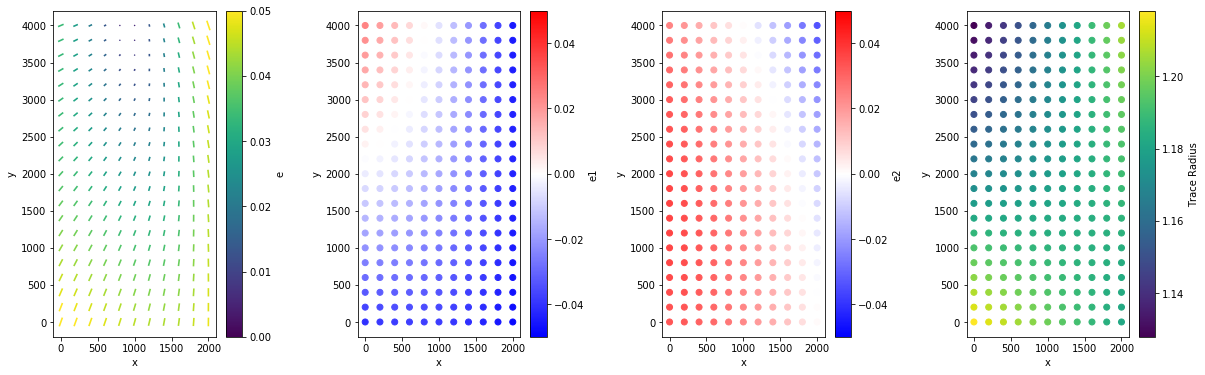

In [13]:
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 4, 1)
plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 4, 2)
plt.scatter(xx, yy, c=e1, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e1')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 4, 3)
plt.scatter(xx, yy, c=e2, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e2')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 4, 4)
plt.scatter(xx, yy, c=size)
colorbar = plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')

## Part 2: Source Catalog Shape Measurements

The source catalogs include many measurements of source shapes and PSF model shapes

In [14]:
# I'm still learning how to use regular expressions...
#import re
#list(filter(re.compile(".*shape*"), src.schema.getOrderedNames()))

In [15]:
# Columns for shape measurements
for name in src.schema.getOrderedNames():
    if 'shape' in name.lower():
        print(name)

base_Blendedness_flag_noShape
base_SdssShape_xx
base_SdssShape_yy
base_SdssShape_xy
base_SdssShape_xxSigma
base_SdssShape_yySigma
base_SdssShape_xySigma
base_SdssShape_x
base_SdssShape_y
base_SdssShape_flux
base_SdssShape_fluxSigma
base_SdssShape_psf_xx
base_SdssShape_psf_yy
base_SdssShape_psf_xy
base_SdssShape_flux_xx_Cov
base_SdssShape_flux_yy_Cov
base_SdssShape_flux_xy_Cov
base_SdssShape_flag
base_SdssShape_flag_unweightedBad
base_SdssShape_flag_unweighted
base_SdssShape_flag_shift
base_SdssShape_flag_maxIter
base_SdssShape_flag_psf
ext_shapeHSM_HsmPsfMoments_x
ext_shapeHSM_HsmPsfMoments_y
ext_shapeHSM_HsmPsfMoments_xx
ext_shapeHSM_HsmPsfMoments_yy
ext_shapeHSM_HsmPsfMoments_xy
ext_shapeHSM_HsmPsfMoments_flag
ext_shapeHSM_HsmPsfMoments_flag_no_pixels
ext_shapeHSM_HsmPsfMoments_flag_not_contained
ext_shapeHSM_HsmPsfMoments_flag_parent_source
ext_shapeHSM_HsmShapeRegauss_e1
ext_shapeHSM_HsmShapeRegauss_e2
ext_shapeHSM_HsmShapeRegauss_sigma
ext_shapeHSM_HsmShapeRegauss_resolution
ext_s

There are also "slots" defined for default measurements

In [16]:
# How are the slots defined?
for slot in ['slot_PsfShape', 'slot_Shape']:
    print('%s -> %s'%(slot, src.schema.getAliasMap()[slot]))

slot_PsfShape -> ext_shapeHSM_HsmPsfMoments
slot_Shape -> ext_shapeHSM_HsmSourceMoments


To figure out what these columns mean, look at https://arxiv.org/abs/1705.06745

**Non PSF-corrected shapes**

SDSS algorithm:

`base_SdssShape_xx/xy/yy` = Adaptive moments in arcsec$^2$, SDSS algorithm

`base_SdssShape_psf_xx/xy/yy` = Adaptive moments of PSF evaluated at object position in arcsec$^2$, SDSS algorithm

HSM algorithm: 

_Galaxy shapes are estimated on the coadded i-band images using the re-Gaussianization PSF correction method (Hirata & Seljak 2003)... In the course of the re-Gaussianization PSF-correction method, corrections are applied to account for dilution of the observed shape by the PSF, including the non-Gaussianity of both the PSF and the galaxy surface brightness profiles._

`ext_shapeHSM_HsmPsfMoments_xx/xy/yy` = Adaptive moments of PSF evaluated at object position in arcsec$^2$, HSM algorithm

`ext_shapeHSM_HsmSourceMoments_xx/xy/yy` = Adaptive moments in arcsec$^2$, not PSF-corrected , HSM algorithm

`ext_shapeHSM_HsmSourceMomentsRound_xx/xy/yy` = ??

**Regaussianization shapes based on data alone, PSF-corrected**

`ext_shapeHSM_HsmShapeRegauss_e1/e2` = distortion in sky coordinates estimated by regaussianization method defined in distortion, HSM algorithm (**NEED TO CHECK IF THESE ARE SKY OR INSTRUMENT COORDINATES**)

`ext_shapeHSM_HsmShapeRegauss_sigma` = non-calibrated shape measurement noise, HSM algorithm

`ext_shapeHSM_HsmShapeRegauss_resolution` = resolution of galaxy image defined in equation (4) of https://arxiv.org/abs/1705.06745, HSM algorithm

With those definitions in mind, now verify that the PSF models from SDSS and HSM algorithms are consistent by comparing adaptive moments of the PSF. The plot below shows the ratio of adaptive moment sizes is very nearly unity. The plot also shows no trend in adaptive moments with respect to how well the source is resolved (i.e., source size), which is as expected since we are comparing PSF models as oppose to measurements for individual sources.

Text(0,0.5,'base_SdssShape_psf / ext_shapeHSM_HsmPsfMoments')

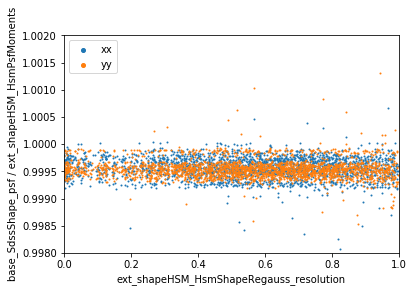

In [44]:
plt.figure()
plt.scatter(src['ext_shapeHSM_HsmShapeRegauss_resolution'], 
            src['base_SdssShape_psf_xx'] / src['ext_shapeHSM_HsmPsfMoments_xx'], s=1, label='xx')
plt.scatter(src['ext_shapeHSM_HsmShapeRegauss_resolution'], 
            src['base_SdssShape_psf_yy'] / src['ext_shapeHSM_HsmPsfMoments_yy'], s=1, label='yy')
plt.xlim(0., 1.)
plt.ylim(1. - 2.e-3, 1. + 2.e-3)
plt.legend(loc='upper left', markerscale=4)
plt.xlabel('ext_shapeHSM_HsmShapeRegauss_resolution')
plt.ylabel('base_SdssShape_psf / ext_shapeHSM_HsmPsfMoments')

To illustrate the difference between the PSF-corrected and non-PSF-corrected quantities within the HSM algorithm, now compare the ellipticity computed from the adaptive moments (not-PSF corrected) with the ellipticity including PSF-corrections. In the plot below, we see a clear trend with the amount of source resolution. For sources that are increasingly resolved, the PSF-corrected and non-PSF-corrected ellipticities converge. For sources that are not well resolved, the PSF-corrected and non-PSF-corrected ellipticities diverge.

Text(0,0.5,'HsmSourceMoments_e1 / HsmShapeRegauss_e1')

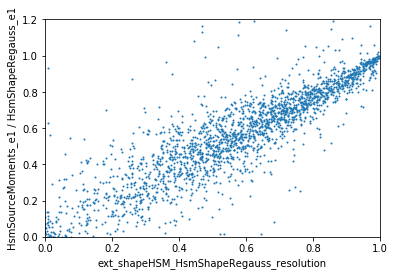

In [48]:
i_xx, i_yy, i_xy = src['ext_shapeHSM_HsmSourceMoments_xx'], src['ext_shapeHSM_HsmSourceMoments_yy'], src['ext_shapeHSM_HsmSourceMoments_xy']
e1_non_psf_corrected = (i_xx - i_yy) / (i_xx + i_yy)
ratio = e1_non_psf_corrected / src['ext_shapeHSM_HsmShapeRegauss_e1']
#trace_radius = np.sqrt((src['base_SdssShape_xx'] + src['base_SdssShape_yy']) / 2.)

plt.figure()
plt.scatter(src['ext_shapeHSM_HsmShapeRegauss_resolution'], ratio, s=1)
plt.xlim(0., 1.)
plt.ylim(0., 1.2)
plt.xlabel('ext_shapeHSM_HsmShapeRegauss_resolution')
plt.ylabel('HsmSourceMoments_e1 / HsmShapeRegauss_e1')

**TODO** Introduce the concept of PSF-model stars and reserve stars here

## Part 3: Characterization

Show a few examples of characterizing shape measurements.

In [83]:
import pandas as pd

In [97]:
df = src.asAstropy().to_pandas()

In [62]:
#src.schema
src['slot_Centroid_x'], src['slot_Centroid_y'], src['coord_ra'], src['coord_dec']

(array([ 767.        , 1216.        , 1379.        , ..., 1991.91091285,
         991.        ,  986.        ]),
 array([4.00000000e+00, 4.00000000e+00, 5.00000000e+00, ...,
        4.09119472e+03, 4.14400000e+03, 4.14900000e+03]),
 array([5.96137725, 5.96137283, 5.96137212, ..., 5.9646495 , 5.96469681,
        5.96470088]),
 array([0.02857022, 0.02892959, 0.02906024, ..., 0.02952523, 0.02871686,
        0.02871281]))

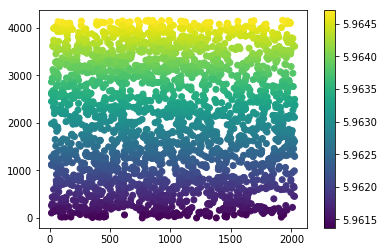

In [65]:
xlabels = pd.cut(src['slot_Centroid_x'], bins=np.linspace(0, 4000, 101), labels=False)
plt.figure()
plt.scatter(src['slot_Centroid_x'], src['slot_Centroid_y'], c=xlabels)
#plt.scatter(src['slot_Centroid_x'], src['slot_Centroid_y'], c=src['coord_ra'])
plt.colorbar()